In [8]:
import numpy as np
import pandas as pd
import gzip
import ast
import pyarrow
print(pyarrow.__version__)
print(pd.__version__)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVR
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.decomposition import TruncatedSVD
from sklearn.mixture import GaussianMixture
import re
import scipy.sparse as sp
from xgboost import XGBRegressor

22.0.0
2.3.3


In [ ]:
rows = []

with gzip.open('data/steam_reviews.json.gz', 'rt') as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        rows.append(ast.literal_eval(line))

df = pd.DataFrame(rows)

In [3]:
df.shape[1]
df.head()

,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,0,2017-12-27,looks like a facebook game,False,1,NaN,NaN,NaN
2,hello?<,14.6,2.0,328100,1,2017-10-16,Better than Minecraft,False,1,2.0,Product received for free,NaN
3,Cyderine916,5.0,64.0,35140,0,2018-01-04,I love and idolized Batman and this game is Ma...,False,1,NaN,NaN,NaN
4,DarklyThinking,16.6,577.0,35140,1,2018-01-04,Still worth playing in 2018.\nProbably my favo...,False,1,NaN,NaN,76561198007483075


In [ ]:
def mark_caps(word):
    # Mark words that are all uppercase and longer than 1 character
    if word.isupper() and len(word) > 1:
        return word.lower() + " <allcaps>"
    return word

def clean_text(text, mark_allcaps=True):
    if not isinstance(text, str):
        return ""

    # Normalize any sequence of ♥ to a token
    text = re.sub(r'[♥]+', ' <censored> ', text)

    # Replace repeated punctuation / emojis with tokens
    text = re.sub(r'!{2,}', ' <exclaim> ', text)   # !!! → <exclaim>
    text = re.sub(r'\?{2,}', ' <question> ', text) # ??? → <question>
    text = re.sub(r':\)', ' <smile> ', text)       # :) → <smile>

    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)

    if mark_allcaps:
        text = ' '.join(mark_caps(w) for w in text.split())

    text = text.lower()

    # Allow letters, digits, common sentiment punctuation, +-/ and the token brackets <>
    text = re.sub(r'[^a-z0-9<>\s!\?\.,:\+\-/]', ' ', text)

    # Collapse multiple spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text


df['cleaned_text'] = df['text'].apply(clean_text)
df['received_free'] = (df['compensation'] == 'Product received for free').astype(int)
df = df.drop(columns=['compensation'])
df['found_funny'] = df['found_funny'].fillna(0).astype(int)
df['found_funny_log'] = np.log1p(df['found_funny'])
df['hours'] = np.log1p(df['hours'])
df['date'] = pd.to_datetime(df['date'], errors='coerce')

df = df.dropna(subset=['hours', 'products', 'date', 'user_id', 'product_id'])
df['review_month'] = df['date'].dt.month
df['review_dow'] = df['date'].dt.dayofweek

df.to_parquet('steam_reviews.parquet', index=False)

In [5]:
df.shape[0]

3158609

In [ ]:
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

y_train = train_df['hours'].values
y_val = val_df['hours'].values
y_test = test_df['hours'].values

# -------------------------
# 3. Text Features: TF-IDF
# -------------------------
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
X_train_text = tfidf.fit_transform(train_df['cleaned_text'])
X_val_text = tfidf.transform(val_df['cleaned_text'])
X_test_text = tfidf.transform(test_df['cleaned_text'])

# -------------------------
# 4. Numeric Features
# -------------------------
numeric_features = ['products', 'found_funny', 'review_month', 'review_dow', 'received_free']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features)
])

X_train_meta = preprocessor.fit_transform(train_df)
X_val_meta = preprocessor.transform(val_df)
X_test_meta = preprocessor.transform(test_df)

# -------------------------
# 5. Combine text + meta
# -------------------------
X_train = sp.hstack([X_train_text, X_train_meta])
X_val = sp.hstack([X_val_text, X_val_meta])
X_test = sp.hstack([X_test_text, X_test_meta])

# -------------------------
# 6. Train LinearSVR
# -------------------------
svr = SGDRegressor(
    loss='epsilon_insensitive',
    max_iter=1000,
    tol=1e-3,
    alpha=1e-4,
    random_state=42
)
svr.fit(X_train, y_train)
y_train_svr = svr.predict(X_train)
y_val_svr = svr.predict(X_val)
y_test_svr = svr.predict(X_test)

# -------------------------
# 7. Collaborative Filtering / MF (optimized)
# -------------------------
train_residuals = y_train - y_train_svr

user_codes = df['user_id'].astype('category').cat.codes
item_codes = df['product_id'].astype('category').cat.codes

train_user_idx = train_df['user_id'].astype('category').cat.codes
train_item_idx = train_df['product_id'].astype('category').cat.codes

R = sp.coo_matrix(
    (train_residuals, (train_user_idx, train_item_idx)),
    shape=(len(user_codes), len(item_codes))  # full user-item space
)


svd = TruncatedSVD(
    n_components=30,
    n_iter=2,
    random_state=42
)
user_factors = svd.fit_transform(R)
item_factors = svd.components_.T

user_map = dict(zip(df['user_id'], user_codes))
item_map = dict(zip(df['product_id'], item_codes))

user_map = dict(zip(df['user_id'], user_codes))
item_map = dict(zip(df['product_id'], item_codes))

def mf_predict(df_subset):
    u_idx = df_subset['user_id'].map(user_map).values
    i_idx = df_subset['product_id'].map(item_map).values
    return np.array([user_factors[u] @ item_factors[i] for u, i in zip(u_idx, i_idx)])


train_pred_mf = mf_predict(train_df)
val_pred_mf   = mf_predict(val_df)
test_pred_mf  = mf_predict(test_df)

# -------------------------
# 8. EM / Gaussian Mixture on residuals
# -------------------------
residuals = (y_train - y_train_svr).reshape(-1, 1)

gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(residuals)

cluster_means = gmm.means_.flatten()

# -------------------------
# 9. Combine SVR + MF + GMM residuals
# -------------------------
def combined_prediction(svr_pred, mf_pred, gmm, cluster_means, alpha=0.5):
    # residual distribution conditioning is based on MF-SVR gap
    residual_guess = (mf_pred - svr_pred).reshape(-1, 1)
    probs = gmm.predict_proba(residual_guess)
    expected_residual = np.dot(probs, cluster_means)
    return alpha * svr_pred + (1 - alpha) * mf_pred + expected_residual

y_val_combined = combined_prediction(y_val_svr, val_pred_mf, gmm, cluster_means)
y_test_combined = combined_prediction(y_test_svr, test_pred_mf, gmm, cluster_means)

# -------------------------
# 10. Evaluation
# -------------------------
def evaluate(y_true, y_pred, name=""):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name} RMSE: {rmse:.4f}, R2: {r2:.4f}")

evaluate(y_val, y_val_combined, "Validation")
evaluate(y_test, y_test_combined, "Test")

print("Pipeline ready.")
print("X_train shape:", X_train.shape)
print("Sparse user-item matrix R:", R.shape)
print("User factors:", user_factors.shape)
print("Item factors:", item_factors.shape)

Validation RMSE: 3.4619, R2: -2.7664
Test RMSE: 3.4585, R2: -2.7592
Pipeline ready.
X_train shape: (1895165, 1005)
Sparse user-item matrix R: (3158609, 3158609)
User factors: (3158609, 30)
Item factors: (3158609, 30)


In [ ]:
## XGBoost version

# ===============================================================
# 2. Train/Validation/Test split
# ===============================================================
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)
val_df, test_df   = train_test_split(temp_df, test_size=0.5, random_state=42)

y_train = train_df['hours'].values
y_val   = val_df['hours'].values
y_test  = test_df['hours'].values


# ===============================================================
# 3. TF-IDF (fast)
# ===============================================================
tfidf = TfidfVectorizer(
    max_features=1000,
    stop_words='english'
)

X_train_text = tfidf.fit_transform(train_df['cleaned_text'])
X_val_text   = tfidf.transform(val_df['cleaned_text'])
X_test_text  = tfidf.transform(test_df['cleaned_text'])


# ===============================================================
# 4. Numeric metadata features
# ===============================================================
numeric = ['products','found_funny','review_month','review_dow','received_free']

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric)
])

X_train_meta = preprocessor.fit_transform(train_df)
X_val_meta   = preprocessor.transform(val_df)
X_test_meta  = preprocessor.transform(test_df)


# ===============================================================
# 5. Combine text + meta features
# ===============================================================
X_train = sp.hstack([X_train_text, X_train_meta])
X_val   = sp.hstack([X_val_text,   X_val_meta])
X_test  = sp.hstack([X_test_text,  X_test_meta])


# ===============================================================
# 6. XGBoost Model (optimized for speed + accuracy)
# ===============================================================
xgb = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.7,
    tree_method='hist',
    n_jobs=-1,
    verbosity=1
)

xgb.fit(X_train, y_train)

train_pred_xgb = xgb.predict(X_train)
val_pred_xgb   = xgb.predict(X_val)
test_pred_xgb  = xgb.predict(X_test)


# ===============================================================
# 7. Matrix Factorization (MF) on residuals
# ===============================================================

# residuals for MF to learn
train_residuals = y_train - train_pred_xgb

# categorical encoding
user_codes = df['user_id'].astype('category').cat.codes
item_codes = df['product_id'].astype('category').cat.codes

# Slice codes for training set
train_user_idx = train_df['user_id'].astype('category').cat.codes
train_item_idx = train_df['product_id'].astype('category').cat.codes

R = sp.coo_matrix(
    (train_residuals, (train_user_idx, train_item_idx)),
    shape=(len(user_codes), len(item_codes))
)

# fast MF
svd = TruncatedSVD(
    n_components=30,
    n_iter = 2,
    random_state=42
)
user_factors = svd.fit_transform(R)
item_factors = svd.components_.T

user_map = dict(zip(df['user_id'], user_codes))
item_map = dict(zip(df['product_id'], item_codes))

def mf_predict(df_subset):
    u_idx = df_subset['user_id'].map(user_map).values
    i_idx = df_subset['product_id'].map(item_map).values
    return np.array([user_factors[u] @ item_factors[i] for u, i in zip(u_idx, i_idx)])


train_pred_mf = mf_predict(train_df)
val_pred_mf   = mf_predict(val_df)
test_pred_mf  = mf_predict(test_df)


# ===============================================================
# 8. Combined Prediction (Hybrid)
# ===============================================================
train_pred = train_pred_xgb + train_pred_mf
val_pred   = val_pred_xgb   + val_pred_mf
test_pred  = test_pred_xgb  + test_pred_mf


# ===============================================================
# 9. Evaluation
# ===============================================================
def evaluate(y, yhat, name):
    rmse = np.sqrt(mean_squared_error(y, yhat))
    r2   = r2_score(y, yhat)
    print(f"{name}: RMSE={rmse:.4f}, R2={r2:.4f}")

evaluate(y_val, val_pred, "Validation")
evaluate(y_test, test_pred, "Test")

print("Pipeline complete.")

Validation: RMSE=1.6083, R2=0.1870
Test: RMSE=1.6083, R2=0.1870
Pipeline complete.


In [17]:
# ===========================
# 1. Define evaluation function
# ===========================
def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return mse, mae

# ===========================
# 2. Compute metrics for all models
# ===========================
models = {
    "XGBoost": (train_pred_xgb, val_pred_xgb, test_pred_xgb),
    "Matrix Factorization": (train_pred_mf, val_pred_mf, test_pred_mf),
    "Hybrid": (train_pred, val_pred, test_pred)
}

metrics_dict = {}

for name, (train_pred, val_pred, test_pred) in models.items():
    metrics_dict[name] = {
        "Train MSE, MAE": compute_metrics(y_train, train_pred),
        "Val MSE, MAE": compute_metrics(y_val, val_pred),
        "Test MSE, MAE": compute_metrics(y_test, test_pred)
    }

# Convert metrics to a DataFrame for display
rows = []
for model_name, scores in metrics_dict.items():
    rows.append({
        "Model": model_name,
        "Train MSE": scores["Train MSE, MAE"][0],
        "Train MAE": scores["Train MSE, MAE"][1],
        "Val MSE": scores["Val MSE, MAE"][0],
        "Val MAE": scores["Val MSE, MAE"][1],
        "Test MSE": scores["Test MSE, MAE"][0],
        "Test MAE": scores["Test MSE, MAE"][1],
    })

metrics_df = pd.DataFrame(rows)
print(metrics_df)

                  Model  Train MSE  Train MAE    Val MSE   Val MAE   Test MSE  \
0               XGBoost   2.516844   1.272123   2.586690  1.290086   2.586678   
1  Matrix Factorization  12.890573   3.114858  12.886192  3.115175  12.864743   
2                Hybrid   2.533893   1.275503   2.569420  1.284269   2.567999   

   Test MAE  
0  1.290084  
1  3.111738  
2  1.284104  


In [ ]:
# XGBoost + Ridge + MF Hybrid Version

# ===============================================================
# 2. Train/Validation/Test split
# ===============================================================
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

y_train = train_df['hours'].values
y_val = val_df['hours'].values
y_test = test_df['hours'].values
print(f"Data split: Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")


# ===============================================================
# 3. TF-IDF (Text Features)
# ===============================================================
tfidf = TfidfVectorizer(
    max_features=1000,
    stop_words='english'
)

X_train_text = tfidf.fit_transform(train_df['cleaned_text'])
X_val_text = tfidf.transform(val_df['cleaned_text'])
X_test_text = tfidf.transform(test_df['cleaned_text'])
print(f"TF-IDF features extracted: {X_train_text.shape[1]}")


# ===============================================================
# 4. Numeric metadata features
# ===============================================================
numeric = ['products','found_funny','review_month','review_dow','received_free']

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric)
])

X_train_meta = preprocessor.fit_transform(train_df)
X_val_meta = preprocessor.transform(val_df)
X_test_meta = preprocessor.transform(test_df)
print(f"Numeric features scaled: {X_train_meta.shape[1]}")


# ===============================================================
# 5. Combine text + meta features
# ===============================================================
X_train = sp.hstack([X_train_text, X_train_meta])
X_val = sp.hstack([X_val_text, X_val_meta])
X_test = sp.hstack([X_test_text, X_test_meta])
print(f"Combined feature matrix shape: {X_train.shape}")


# ===============================================================
# 6. XGBoost Model (Predictor 1)
# ===============================================================
xgb = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    max_depth=8,
    learning_rate=0.05,
    tree_method='hist',
    verbosity=0 # Set to 1 if you want output during training
)

print("\nTraining XGBoost...")
xgb.fit(X_train, y_train)

train_pred_xgb = xgb.predict(X_train)
val_pred_xgb = xgb.predict(X_val)
test_pred_xgb = xgb.predict(X_test)


# ===============================================================
# 7. Ridge Regression Model (Predictor 2)
#    Added for blending/stacking
# ===============================================================
ridge = Ridge(alpha=1.0) 
print("Training Ridge Regression...")
ridge.fit(X_train, y_train)

train_pred_ridge = ridge.predict(X_train)
val_pred_ridge = ridge.predict(X_val)
test_pred_ridge = ridge.predict(X_test)


# ===============================================================
# 8. Matrix Factorization (MF) on Combined Residuals (Predictor 3)
#    MF learns the error left over by the average of XGBoost and Ridge
# ===============================================================

# Calculate the average prediction from the two primary models
train_base_pred = (train_pred_xgb + train_pred_ridge) / 2
val_base_pred = (val_pred_xgb  + val_pred_ridge) / 2
test_base_pred = (test_pred_xgb + test_pred_ridge) / 2

# Residuals for MF to learn
train_residuals = y_train - train_base_pred

user_codes = df['user_id'].astype('category').cat.codes
item_codes = df['product_id'].astype('category').cat.codes

train_user_idx = train_df['user_id'].astype('category').cat.codes.values
train_item_idx = train_df['product_id'].astype('category').cat.codes.values

R = sp.coo_matrix(
    (train_residuals, (train_user_idx, train_item_idx)),
    shape=(len(user_codes.unique()), len(item_codes.unique()))
)

svd = TruncatedSVD(
    n_components=30,
    n_iter = 2,
    random_state=42
)

print("Training Matrix Factorization on residuals...")
user_factors = svd.fit_transform(R)
item_factors = svd.components_.T

user_map = dict(zip(df['user_id'], user_codes))
item_map = dict(zip(df['product_id'], item_codes))

def mf_predict(df_subset):
    # Map IDs to the trained indices
    u_idx = df_subset['user_id'].map(user_map).values
    i_idx = df_subset['product_id'].map(item_map).values

    predictions = []
    for u, i in zip(u_idx, i_idx):
        if u < user_factors.shape[0] and i < item_factors.shape[0]:
            predictions.append(user_factors[u] @ item_factors[i])
        else:
            predictions.append(0.0)
    return np.array(predictions)


train_pred_mf = mf_predict(train_df)
val_pred_mf = mf_predict(val_df)
test_pred_mf = mf_predict(test_df)


# ===============================================================
# 9. Combined Prediction (Hybrid - Blended Base + MF Residuals)
# ===============================================================
# Final Prediction = (Avg XGB + Ridge) + MF Residual
train_pred = train_base_pred + train_pred_mf
val_pred = val_base_pred + val_pred_mf
test_pred = test_base_pred + test_pred_mf


# ===============================================================
# 10. Evaluation
# ===============================================================
def evaluate(y, yhat, name):
    rmse = np.sqrt(mean_squared_error(y, yhat))
    mse = mean_squared_error(y, yhat)
    mae = mean_absolute_error(y, yhat)
    r2  = r2_score(y, yhat)
    print(f"{name} Results: RMSE={rmse:.4f}, MSE={mse:.4f}, MAE={mae:.4f}, R2={r2:.4f}")

print("\n--- Model Evaluation ---")
evaluate(y_train, train_pred, "Training Set")
evaluate(y_val, val_pred, "Validation Set (XGB+Ridge+MF)")
evaluate(y_test, test_pred, "Test Set (XGB+Ridge+MF)")
print("-" * 30)

# Also show individual base model results for comparison
print("\n--- Base Model Validation Comparison ---")
evaluate(y_val, val_pred_xgb, "XGBoost Only")
evaluate(y_val, val_pred_ridge, "Ridge Only")
evaluate(y_val, val_base_pred, "XGBoost + Ridge Average")


print("\nPipeline complete.")

Data split: Train=1895165, Val=631722, Test=631722
TF-IDF features extracted: 1000
Numeric features scaled: 5
Combined feature matrix shape: (1895165, 1005)

Training XGBoost...
Training Ridge Regression...
Training Matrix Factorization on residuals...

--- Model Evaluation ---
Training Set Results: RMSE=1.5918, MSE=2.5339, MAE=1.2755, R2=0.2052
Validation Set (XGB+Ridge+MF) Results: RMSE=1.6029, MSE=2.5694, MAE=1.2843, R2=0.1925
Test Set (XGB+Ridge+MF) Results: RMSE=1.6025, MSE=2.5680, MAE=1.2841, R2=0.1929
------------------------------

--- Base Model Validation Comparison ---
XGBoost Only Results: RMSE=1.6083, MSE=2.5867, MAE=1.2901, R2=0.1871
Ridge Only Results: RMSE=1.6180, MSE=2.6180, MAE=1.2949, R2=0.1772
XGBoost + Ridge Average Results: RMSE=1.6029, MSE=2.5694, MAE=1.2843, R2=0.1925

Pipeline complete.


In [ ]:
# ===============================================================
# 3. Grid Search Setup and Execution
# ===============================================================

param_grid = {
    'alpha': np.logspace(-3, 3, 7) 
}

scorer = make_scorer(mean_squared_error, greater_is_better=False)

ridge = Ridge(random_state=42)

print("\nStarting 5-Fold Cross-Validation Grid Search for Ridge Alpha...")
grid_search = GridSearchCV(
    estimator=ridge, 
    param_grid=param_grid, 
    scoring=scorer,
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)


# ===============================================================
# 4. Results & Final Validation Prediction
# ===============================================================
best_alpha = grid_search.best_params_['alpha']
best_cv_mse = -grid_search.best_score_ 
best_cv_rmse = np.sqrt(best_cv_mse)

optimal_ridge_model = grid_search.best_estimator_

val_pred_ridge = optimal_ridge_model.predict(X_val)

val_mse = mean_squared_error(y_val, val_pred_ridge)
val_rmse = np.sqrt(val_mse)

print("\n" + "="*50)
print("        RIDGE ALPHA OPTIMIZATION AND EVALUATION          ")
print("="*50)
print(f"Optimal Alpha (λ) Found: {best_alpha:.4f}")
print(f"CV-Average MSE (Train Set): {best_cv_mse:.4f}")
print(f"CV-Average RMSE (Train Set): {best_cv_rmse:.4f}")
print("-" * 50)
print("STANDALONE VALIDATION SET PERFORMANCE:")
print(f"Ridge-Only Validation MSE: {val_mse:.4f}")
print(f"Ridge-Only Validation RMSE: {val_rmse:.4f}")
print("="*50)

train_pred = train_base_pred + train_pred_mf
val_pred = val_base_pred + val_pred_mf
test_pred = test_base_pred + test_pred_mf


# ===============================================================
# 10. Evaluation
# ===============================================================
def evaluate(y, yhat, name):
    rmse = np.sqrt(mean_squared_error(y, yhat))
    mse = mean_squared_error(y, yhat)
    mae = mean_absolute_error(y, yhat)
    r2  = r2_score(y, yhat)
    print(f"{name} Results: RMSE={rmse:.4f}, MSE={mse:.4f}, MAE={mae:.4f}, R2={r2:.4f}")

print("\n--- Model Evaluation ---")
evaluate(y_train, train_pred, "Training Set")
evaluate(y_val, val_pred, "Validation Set (XGB+Ridge+MF)")
evaluate(y_test, test_pred, "Test Set (XGB+Ridge+MF)")
print("-" * 30)

# Also show individual base model results for comparison
print("\n--- Base Model Validation Comparison ---")
evaluate(y_val, val_pred_xgb, "XGBoost Only")
evaluate(y_val, val_pred_ridge, "Ridge Only")
evaluate(y_val, val_base_pred, "XGBoost + Ridge Average")


print("\nPipeline complete.")

## different alpha was optimal, but same test RMSE and mse.


Starting 5-Fold Cross-Validation Grid Search for Ridge Alpha...
Fitting 5 folds for each of 7 candidates, totalling 35 fits

        RIDGE ALPHA OPTIMIZATION AND EVALUATION          
Optimal Alpha (λ) Found: 10.0000
CV-Average MSE (Train Set): 2.6198
CV-Average RMSE (Train Set): 1.6186
--------------------------------------------------
STANDALONE VALIDATION SET PERFORMANCE:
Ridge-Only Validation MSE: 2.6179
Ridge-Only Validation RMSE: 1.6180

--- Model Evaluation ---
Training Set Results: RMSE=1.5918, MSE=2.5339, MAE=1.2755, R2=0.2052
Validation Set (XGB+Ridge+MF) Results: RMSE=1.6029, MSE=2.5694, MAE=1.2843, R2=0.1925
Test Set (XGB+Ridge+MF) Results: RMSE=1.6025, MSE=2.5680, MAE=1.2841, R2=0.1929
------------------------------

--- Base Model Validation Comparison ---
XGBoost Only Results: RMSE=1.6083, MSE=2.5867, MAE=1.2901, R2=0.1871
Ridge Only Results: RMSE=1.6180, MSE=2.6179, MAE=1.2950, R2=0.1773
XGBoost + Ridge Average Results: RMSE=1.6029, MSE=2.5694, MAE=1.2843, R2=0.1925

Pi

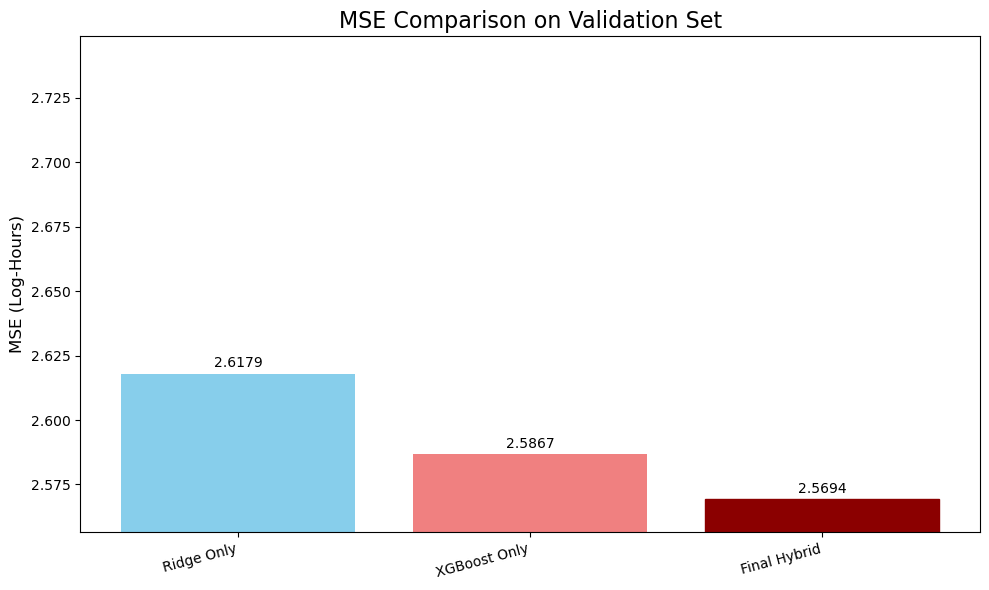

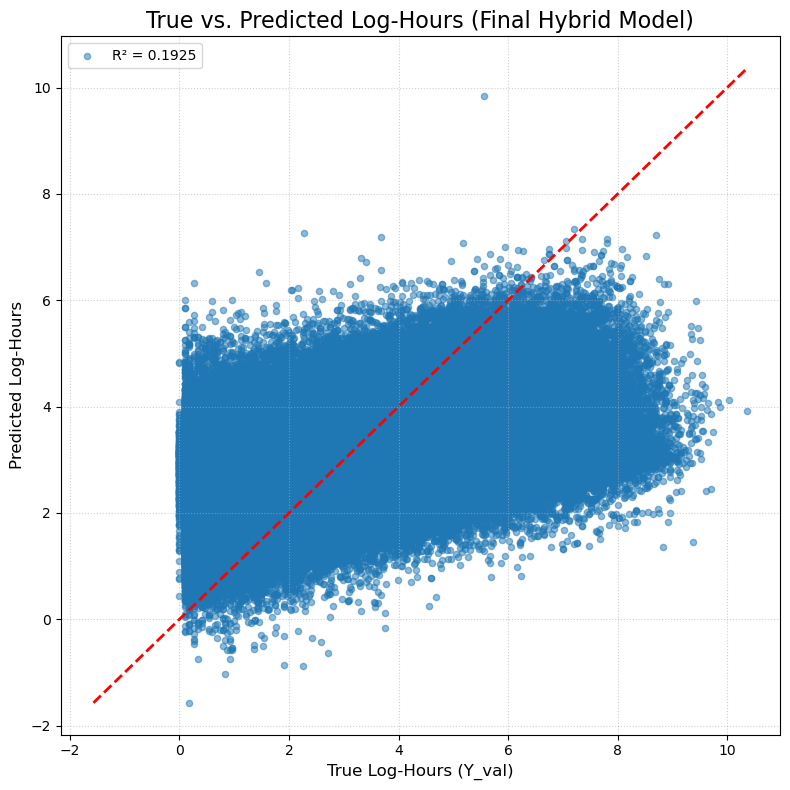

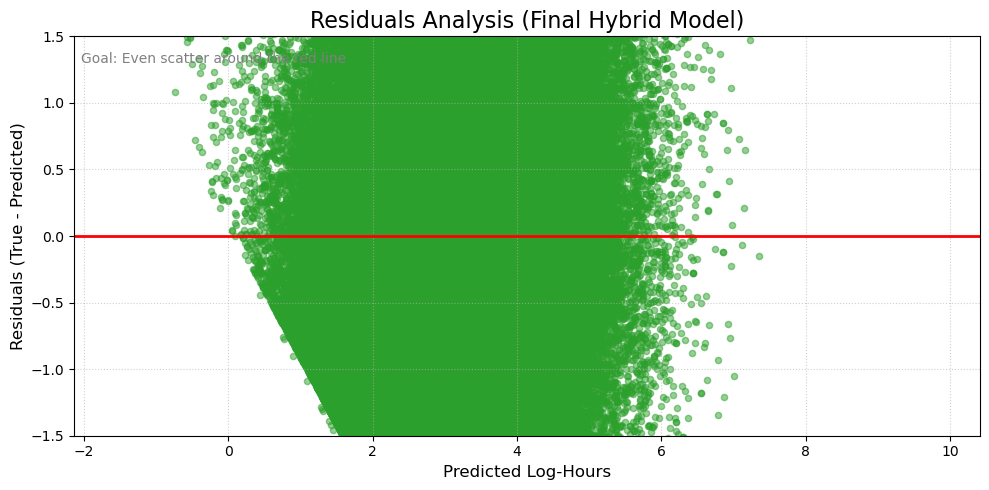

1. Bar Chart: Compares RMSE across models.
2. Scatter Plot: Shows how closely predictions track true values.
3. Residuals Plot: Final Error Distribution (Confirming lack of bias).


In [15]:
models = {
    'Ridge Only': val_pred_ridge,
    'XGBoost Only': val_pred_xgb,
    'Final Hybrid': val_pred,
}

metrics = {name: mean_squared_error(y_val, pred) for name, pred in models.items()}
model_names = list(metrics.keys())
mse_values = list(metrics.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, mse_values, color=['skyblue', 'lightcoral', 'darkblue'])

# Highlight the best model (which is now at index 2)
bars[2].set_color('darkred') 
plt.title('MSE Comparison on Validation Set', fontsize=16)
plt.ylabel('MSE (Log-Hours)', fontsize=12)
plt.xticks(rotation=15, ha='right')

min_mse = min(mse_values)
max_mse = max(mse_values)
plt.ylim(min_mse * 0.995, max_mse * 1.05) 

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + (max_mse * 0.0005), f'{yval:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


# --- 3b. True vs. Predicted Scatter Plot (Final Hybrid Model) ---
plt.figure(figsize=(8, 8))
plt.scatter(y_val, val_pred, alpha=0.5, s=20, c='#1f77b4')

max_val = max(y_val.max(), val_pred.max())
min_val = min(y_val.min(), val_pred.min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Ideal Fit')

r2 = r2_score(y_val, val_pred)

plt.title('True vs. Predicted Log-Hours (Final Hybrid Model)', fontsize=16)
plt.xlabel('True Log-Hours (Y_val)', fontsize=12)
plt.ylabel('Predicted Log-Hours', fontsize=12)
plt.legend([f'R² = {r2:.4f}'], loc='upper left')
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

# --- 3c. Residuals Plot (Final Hybrid Model - Log Hours) ---
residuals = y_val - val_pred

plt.figure(figsize=(10, 5))
plt.scatter(val_pred, residuals, alpha=0.5, s=20, c='#2ca02c')

plt.axhline(0, color='red', linestyle='-', linewidth=2)

plt.title('Residuals Analysis (Final Hybrid Model)', fontsize=16)
plt.xlabel('Predicted Log-Hours', fontsize=12)
plt.ylabel('Residuals (True - Predicted)', fontsize=12)
plt.ylim(-1.5, 1.5)

plt.text(plt.xlim()[0] + 0.1, 1.3, 'Goal: Even scatter around the red line', color='gray', fontsize=10)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

print("1. Bar Chart: Compares RMSE across models.")
print("2. Scatter Plot: Shows how closely predictions track true values.")
print("3. Residuals Plot: Final Error Distribution (Confirming lack of bias).")

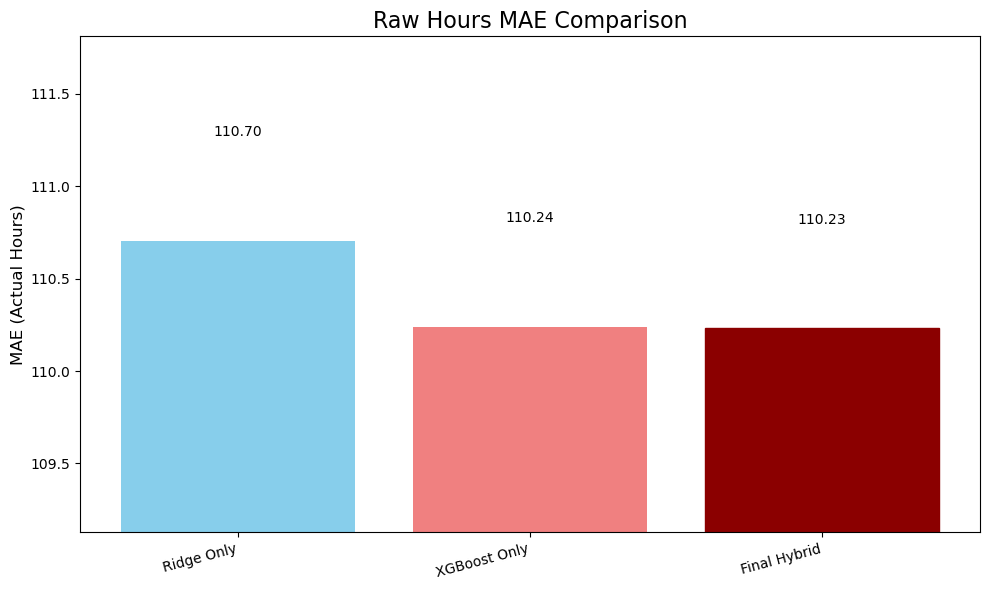

In [16]:
y_val_raw = np.expm1(y_val)
models_raw = {
    'Ridge Only': np.expm1(val_pred_ridge),
    'XGBoost Only': np.expm1(val_pred_xgb),
    'Final Hybrid': np.expm1(val_pred),
}

raw_mae_metrics = {name: mean_absolute_error(y_val_raw, pred) for name, pred in models_raw.items()}
model_names_raw = list(raw_mae_metrics.keys())
raw_mae_values = list(raw_mae_metrics.values())

plt.figure(figsize=(10, 6))
bars_raw = plt.bar(model_names_raw, raw_mae_values, color=['skyblue', 'lightcoral', 'darkblue'])

bars_raw[2].set_color('darkred') 
plt.title('Raw Hours MAE Comparison', fontsize=16) 
plt.ylabel('MAE (Actual Hours)', fontsize=12)
plt.xticks(rotation=15, ha='right')

min_raw_mae = min(raw_mae_values)
max_raw_mae = max(raw_mae_values)
plt.ylim(min_raw_mae * 0.99, max_raw_mae * 1.01)

for bar in bars_raw:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval * 1.005, f'{yval:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()